In [1]:
import networkx as nx 
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import networkx as nx
import torch
import copy
from torch.distributions.bernoulli import Bernoulli
import pandas as pd

from gsnn.models.GSNN import GSNN
from gsnn.models.NN import NN
from gsnn.simulate.nx2pyg import nx2pyg
from gsnn.simulate.datasets import simulate_3_in_3_out

from gsnn.optim.Environment import Environment
from gsnn.optim.RewardScaler import RewardScaler
from gsnn.models.GSNN import GSNN

from sklearn.metrics import roc_auc_score
from gsnn.optim.REINFORCE import REINFORCE
import argparse

from sklearn.metrics import confusion_matrix
import seaborn as sbn

# for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/teddy/miniconda3/envs/gsnn-lib/lib/python3.12/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Reinforcement learning for structure optimization

In many cases, prior knowledge is incomplete, noisy or spurrious for specific prediction tasks. In this example, we will demonstrate how we can use the reinforcement learning for the optimal selection of prior knowledge. 

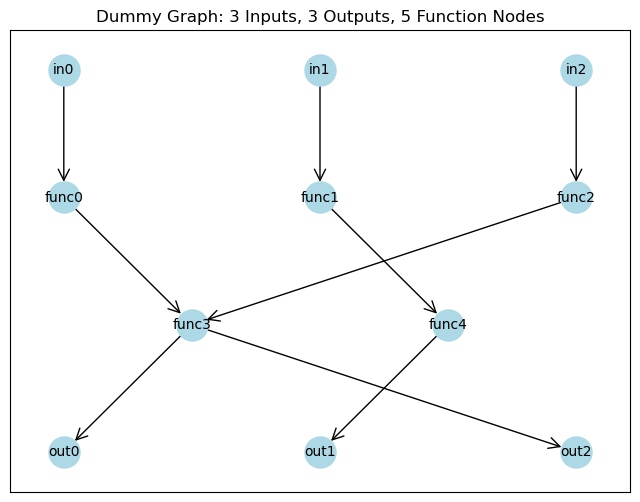

In [2]:
G, pos, x_train, x_test, y_train, y_test, \
    input_nodes, function_nodes, output_nodes = simulate_3_in_3_out(n_train=100, n_test=250, noise_scale=0.01)

plt.figure(figsize=(8, 6))
nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, arrowstyle='->', arrowsize=20)
plt.title("Dummy Graph: 3 Inputs, 3 Outputs, 5 Function Nodes")
plt.show()

In [3]:
data = nx2pyg(G, input_nodes, function_nodes, output_nodes) 

# add some false edges 
edge_index_dict = copy.deepcopy(data.edge_index_dict)

# add some false input edges 
edge_index_dict['input', 'to', 'function']  = torch.cat((edge_index_dict['input', 'to', 'function'], 
                                                         torch.tensor([[0, 0, 1, 1], 
                                                                       [1, 4, 0, 2]], 
                                                                       dtype=torch.long)), dim=-1)


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = torch.utils.data.TensorDataset(x_train, y_train) 
test_dataset = torch.utils.data.TensorDataset(x_test, y_test) 

In [5]:
# GSNN model parameters
model_kwargs = {'edge_index_dict'                 : edge_index_dict, 
                    'node_names_dict'                 : data.node_names_dict,
                    'channels'                        : 5, 
                    'layers'                          : 3, 
                    'dropout'                         : 0.,
                    'init'                            : 'xavier',
                    'residual'                        : True,
                    'share_layers'                    : False,
                    'add_function_self_edges'         : True,
                    'norm'                            : 'batch'}

# GSNN training parameters
training_kwargs = {'lr':1e-2, 
                    'max_epochs':250, 
                    'batch':100,
                    'workers':5, 
                    'weight_decay':1e-6}


# the action edge dict will be used to index the action for each edge 
# if and edge key is not provided, those values will not be optimized (always present)
# to specify a fixed edge within a given key, use the index -1 
action_edge_dict = {('input', 'to', 'function'): torch.arange(edge_index_dict['input', 'to', 'function'].shape[1])}
n_actions = sum([torch.unique(v).numel() for v in action_edge_dict.values()])
true_action = np.array([1.]*3 + [0.]*4)

env = Environment(action_edge_dict, train_dataset, test_dataset, model_kwargs, 
                 training_kwargs, metric='r2', reward_type='best', verbose=False,
                 raise_error_on_fail=True)

hoptim = REINFORCE(env, n_actions, action_labels=true_action, clip=10, eps=1e-8, warmup=3, verbose=True, 
                        entropy=0.1, entropy_decay=0.99, min_entropy=0.0, window=10,
                        init_prob=0.5, lr=1e-1, policy_decay=0)

for iter in range(100): 
    hoptim.step()


	 --> iter: 1 || auroc 0.500 || acc: 0.571 || prob(true_action): 0.008 || last reward: 0.826
	 --> iter: 2 || auroc 0.500 || acc: 0.571 || prob(true_action): 0.008 || last reward: 0.399
	 --> iter: 3 || auroc 0.500 || acc: 0.571 || prob(true_action): 0.008 || last reward: -1.000
	 --> iter: 4 || auroc 0.583 || acc: 0.571 || prob(true_action): 0.008 || last reward: 0.106
	 --> iter: 5 || auroc 0.667 || acc: 0.571 || prob(true_action): 0.009 || last reward: -0.124
	 --> iter: 6 || auroc 0.750 || acc: 0.714 || prob(true_action): 0.010 || last reward: 0.422
	 --> iter: 7 || auroc 0.833 || acc: 0.714 || prob(true_action): 0.011 || last reward: 0.542
	 --> iter: 8 || auroc 0.833 || acc: 0.714 || prob(true_action): 0.012 || last reward: 0.347
	 --> iter: 9 || auroc 0.750 || acc: 0.571 || prob(true_action): 0.012 || last reward: -1.000
	 --> iter: 10 || auroc 0.667 || acc: 0.571 || prob(true_action): 0.012 || last reward: -0.939
	 --> iter: 11 || auroc 0.667 || acc: 0.571 || prob(true_action):

KeyboardInterrupt: 

policy [0.90654624 0.8722362  0.3490573  0.36238298 0.36515486 0.514061
 0.7642834 ]
best_action [1. 1. 1. 1. 1. 0. 0.]
true_action [1. 1. 1. 0. 0. 0. 0.]
best action accuracy: 0.714
final policy auroc: 0.667


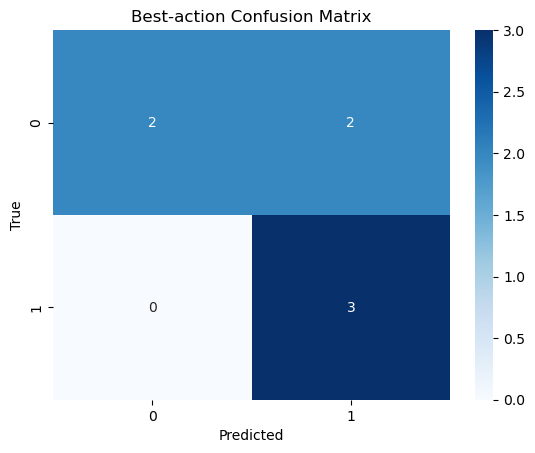

In [6]:
true_action = np.array([1.]*3 + [0.]*4)
best_action = hoptim.best_action.detach().cpu().numpy().ravel()
policy = hoptim.logits.sigmoid().detach().cpu().numpy().ravel()

print('policy', policy)
print('best_action', best_action)
print('true_action', true_action)

acc = np.mean(best_action == true_action)
auroc = roc_auc_score(true_action, policy)

print(f'best action accuracy: {acc:.3f}')
print(f'final policy auroc: {auroc:.3f}')

# plot  confusion matrix 
cm = confusion_matrix(true_action, best_action)

plt.figure() 
sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues') 
plt.title('Best-action Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show() 




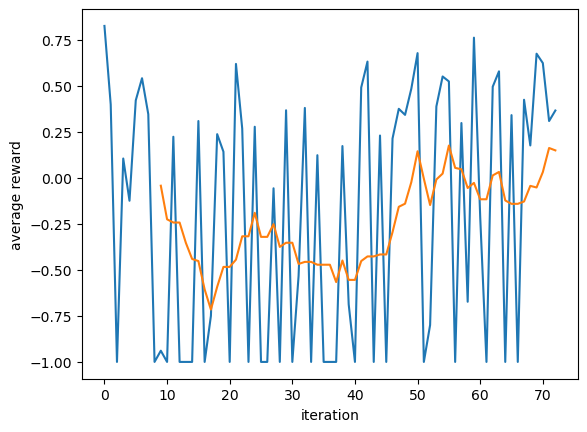

In [7]:
avg_reward = np.array(hoptim.rewards)
plt.figure() 
plt.plot(avg_reward)
plt.plot(pd.Series(avg_reward).rolling(window=10).mean())

plt.xlabel('iteration')
plt.ylabel('average reward')
plt.show()